In this project we explore some of the typical TimeSeries topics such as:

* 1. ACF/PACF
* 2. ARIMA
* 3. Auto-ARIMA
* 4. Prophet
* 5. Augmented Dickey-Fuller (ADF)

In [1]:
import pandas as pd # data processing ,csv file I/0
import numpy as np

import seaborn as sns # Visualization
import matplotlib.pyplot as plt
from colorama import Fore # Print colored text and Fore ==> Foreground

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

In [2]:
df = pd.read_csv("C:/Users/NITHIN/Desktop/github/Time series/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [3]:
# Remove old rows

df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

# Remove not useful columns

df = df.drop(['Depth_to_Groundwater_P24','Temperature_Petrignano'],axis=1)


In [4]:
# Simplify column names 

df.columns = ['date','rainfall','depth_to_groundwater','temperature','drainage_volume','river_hydrometry']

targets = ['depth_to_groundwater']

features = [feature for feature in df.columns if feature not in targets]

df.head()



,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [5]:
from datetime import datetime,date

df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y')
df.head().style.set_properties(subset=['date'],**{'background_color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


# Data Visualization

* Rainfall indicates the quantity of rain falling(mm)
* Temperature indicates the temperature(°c)
* volume indicates the volume of water taken from the drinking water treatment plant(m3)
* Hydrometry indicates the groundlevel (m)


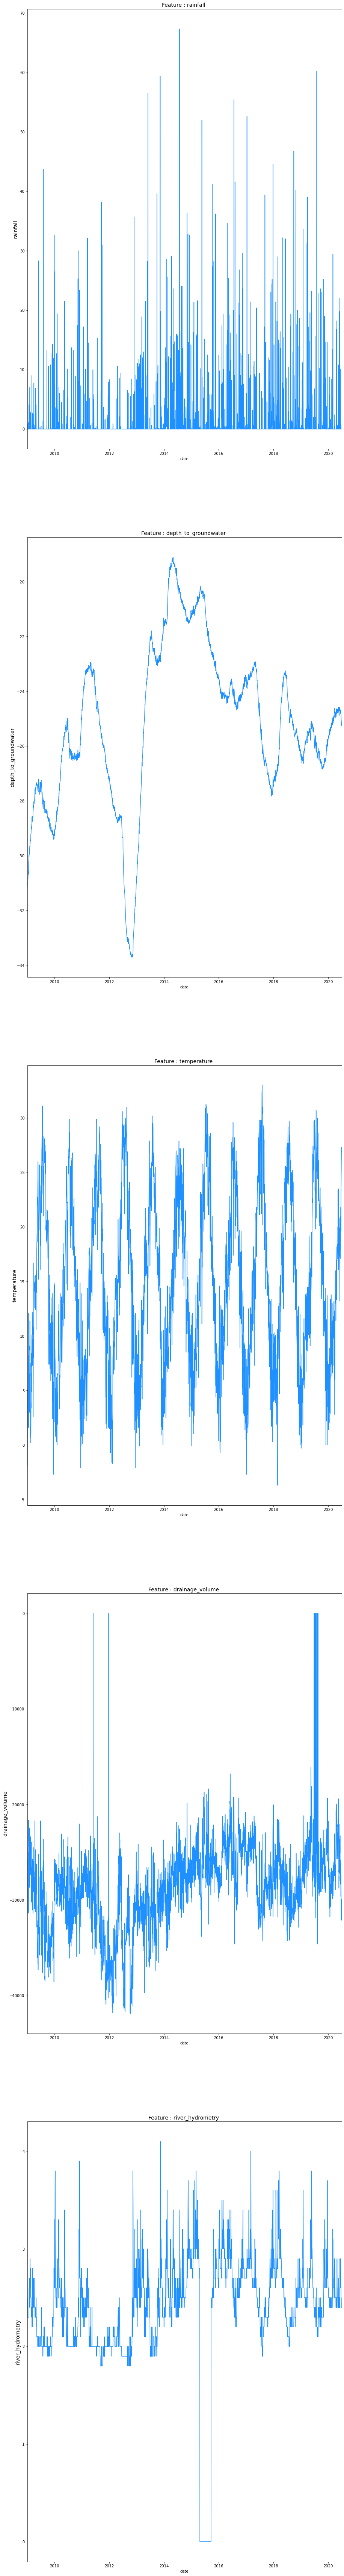

In [6]:
# To complete the data, as naive method, we will use ffill

f,ax = plt.subplots(nrows=5,ncols=1,figsize=(15,125))

for i, column in enumerate(df.drop('date',axis=1).columns):
    sns.lineplot(x=df['date'],y=df[column].fillna(method='ffill'),ax=ax[i],color='dodgerblue')
    
    ax[i].set_title('Feature : {} ' .format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column,fontsize=14)
    
    ax[i].set_xlim([date(2009,1,1), date(2020,6,30)])

# Data Processing 

###### Chronological Order and Equidistant Timestamps



The data should be in chronological order and the timestamps should be equidistant in timeseries.

The chronological order can be achieved by sorting the dataframe by timestamps.

Equidistant timestamps indicates constant time intervals.

To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.


But, first of all, lets see how to check if our dataset is correctly formated!

In [7]:
df = df.sort_values(by="date")

# Check time intervals

df[['delta']]= df['date'] - df['date'].shift(1)
df[['date','delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [8]:
df['delta'].sum(),df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

 This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we donot have to do this additional step

##  Handling Missing Values


As we can see, the dataset has some null values.

Furthermore, plotting the time series reveals that there seem to be some zero values that seems to be nulls for 'drainage_volume', and 'river_hydrometry'. we will have to clean them by replacing them by nan values and filling them afterwards.

In [9]:
df=df.drop('delta',axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

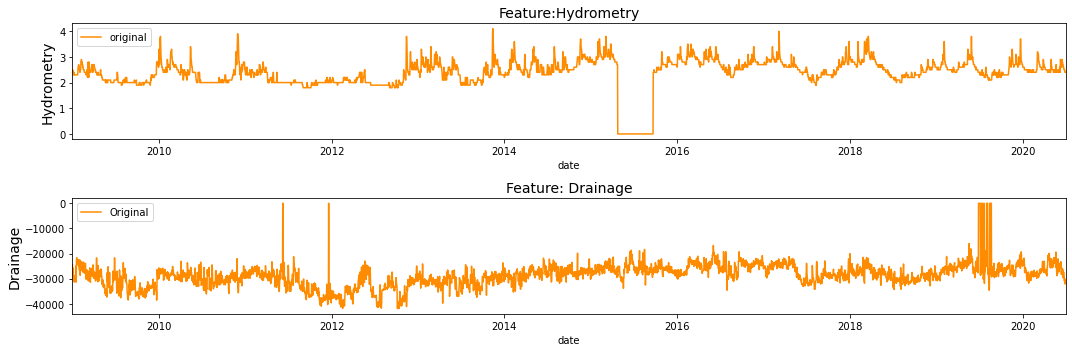

In [10]:
f, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,5))

old_hydrometry = df['river_hydrometry'].copy()

df['river_hydrometry'] = df['river_hydrometry'].replace(0,np.nan)
sns.lineplot(x=df['date'],y=old_hydrometry,ax=ax[0],color='darkorange',label='original')
ax[0].set_title('Feature:Hydrometry',fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry',fontsize=14)
ax[0].set_xlim([date(2009,1,1),date(2020,6,30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume']=df['drainage_volume'].replace(0,np.nan)

sns.lineplot(x=df['date'],y=old_drainage,ax=ax[1],color='darkorange',label='Original')
ax[1].set_title('Feature: Drainage',fontsize=14)
ax[1].set_ylabel(ylabel='Drainage',fontsize=14)
ax[1].set_xlim([date(2009,1,1),date(2020,6,30)])
plt.tight_layout()

Now, let's look at the missing values.

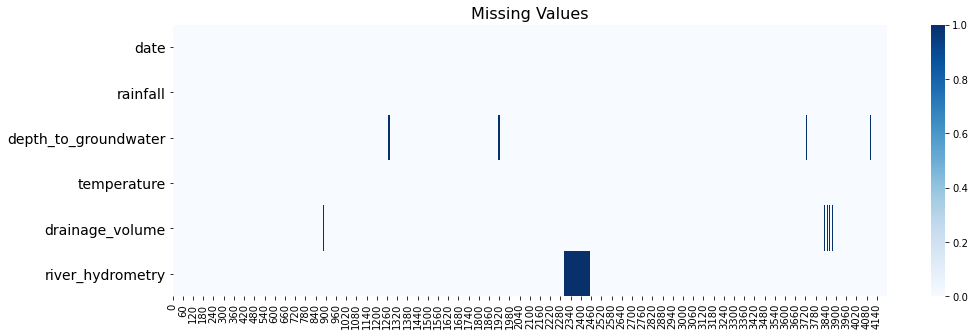

In [11]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)


for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

###### Missing Values, how to handle

* Option 1: FillNaN with outlier or zero

 Here filling with zero seems naive. However filling with -999, is sometimes a good idea.
 

* Option 2 : FillNaN with Mean value

* Option 3 : FillNaN with Last Value with.ffill()

* Option 4 : Fill NaN with Linearly Interpolated Value with.interpolate() 

Filling NaNs with the interpolated values is the best option in this small example but it requires knowledge of the neighbouring value.



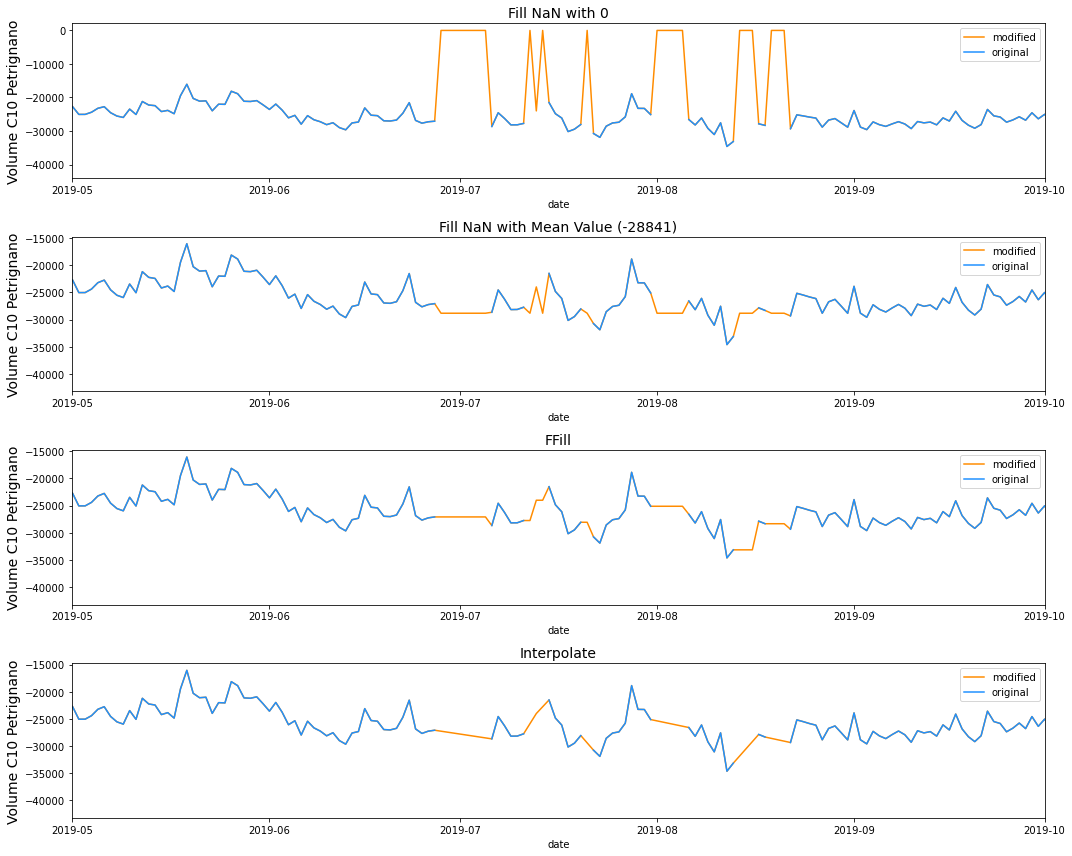

In [12]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)


sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)


sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)


for i in range(4):
    ax[i].set_xlim([date(2019,5,1), date(2019,10,1)])
    
plt.tight_layout()
plt.show()
                   
                   
    


In [13]:
df['drainage_volume']=df['drainage_volume'].interpolate()
df['river_hydrometry']=df['river_hydrometry'].interpolate()
df['depth_to_groundwater']=df['depth_to_groundwater'].interpolate()

## Smoothing data/Resampling




Resampling gives additional Information of data. There are two types of resampling:

* Upsampling  is when the frequency of samples is increased (e.g. days to hours)
* Downsampling is when the frequency of samples is decreased (e.g. days to weeks)



In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean)

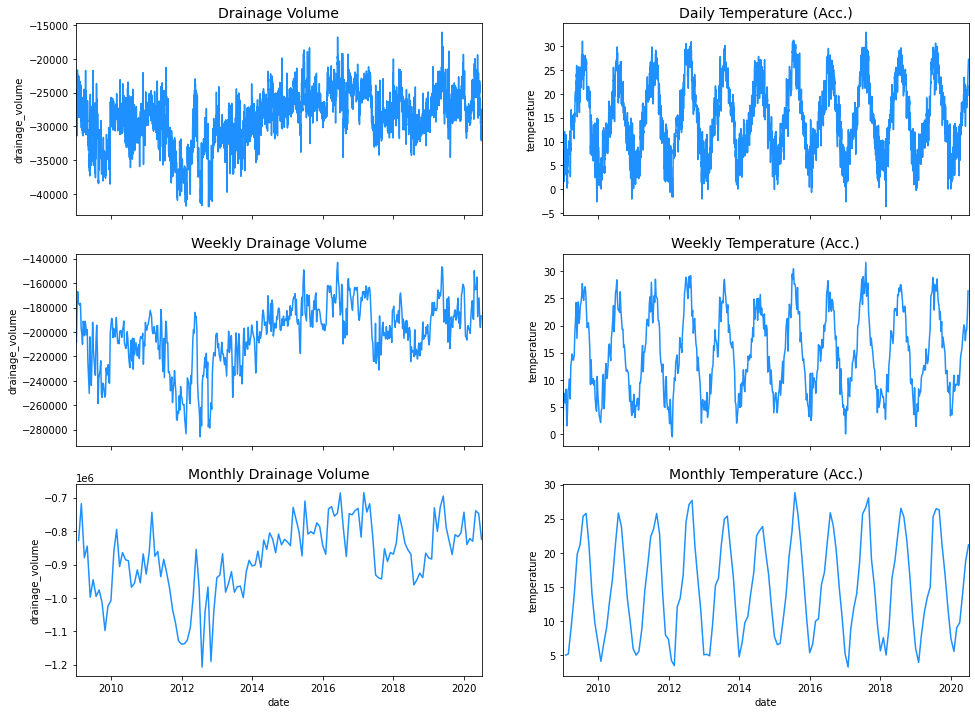

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(df['date'], df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df['date'], df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

In [15]:
# As we can see, downsample the weekly could smooth the data and help with an analysis

downsample = df[['date','depth_to_groundwater','temperature','drainage_volume','river_hydrometry','rainfall']].resample('7D',on='date').mean().reset_index(drop=False)

df = downsample.copy()

## Stationarity

some time series models, such as ARIMA,assume that the underlying data is stationary.

Stationarity has 3 important features:

* Constant mean and mean is not time-dependent
* Constant variance and variance is not time-dependent
* Constant Covariance and Covariance is not time-dependent 

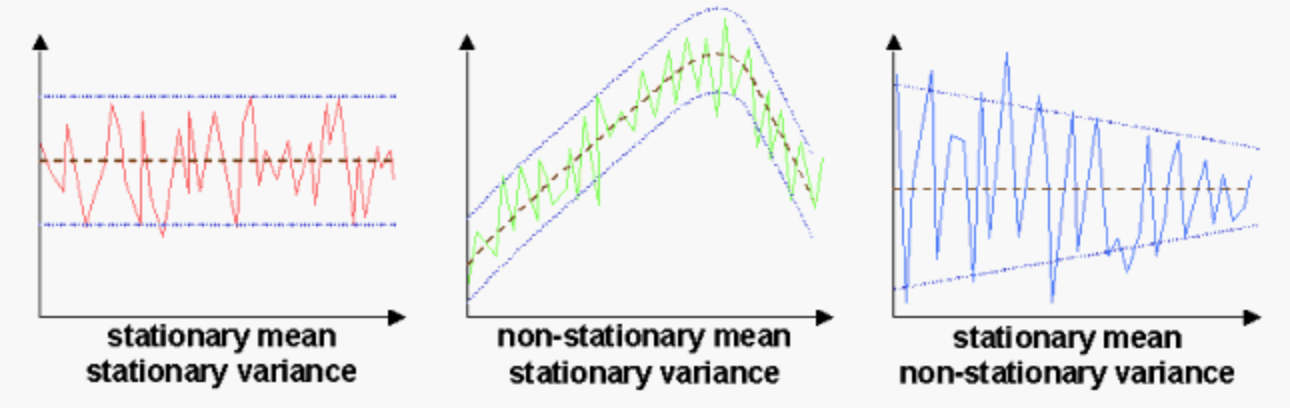

The check for stationarity can be done via three different approaches:

* 1. visually : plot time series and check for trends or seasonality
* 2. Basic Statistics : Split time series and comapare the mean and variance of each partition.
* 3. statistical test : Augmented Dickey Fuller test

In [16]:
# A year has 52 weeks (52 weeks * 7 days per week) approx.

rolling_window = 52

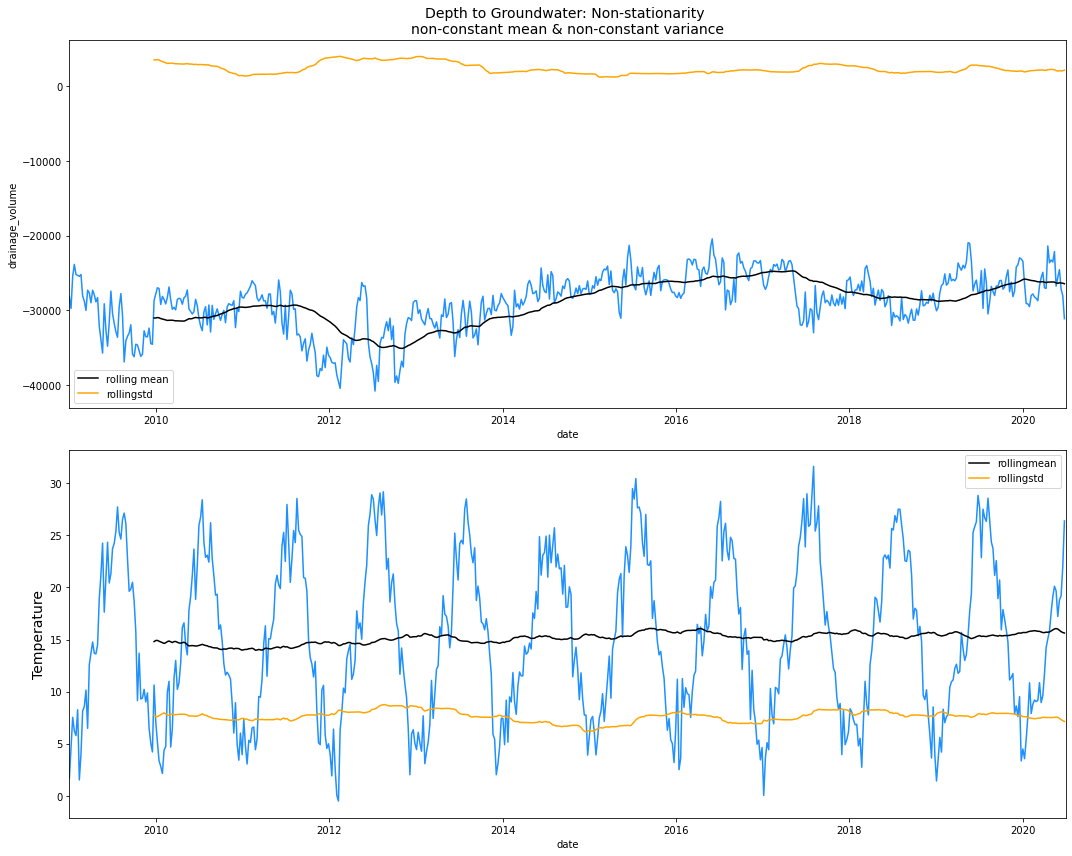

In [17]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,12)) #set plot outlines

# Plot the drainage_volume 
sns.lineplot(x=df['date'],y=df['drainage_volume'],ax=ax[0],color='dodgerblue')

# Plot the rolling mean line
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(),ax=ax[0],color='black',label='rolling mean')

#Plot the standard deviation line
sns.lineplot(x=df['date'],y=df['drainage_volume'].rolling(rolling_window).std(),ax=ax[0],color='orange',label='rollingstd')

#set title to the plot

ax[0].set_title('Depth to Groundwater: Non-stationarity \nnon-constant mean & non-constant variance',fontsize=14)
ax[0].set_xlim([date(2009,1,1),date(2020,6,30)])

# Plot the temperature

sns.lineplot(x=df['date'],y=df['temperature'],ax=ax[1],color='dodgerblue')

# Plot the mean of temperature
sns.lineplot(x=df['date'],y=df['temperature'].rolling(rolling_window).mean(),ax=ax[1],color='black',label='rollingmean')

#Plot the standard deviation of temperature
sns.lineplot(x=df['date'],y=df['temperature'].rolling(rolling_window).std(),ax=ax[1],color='orange',label='rollingstd')

ax[1].set_ylabel(ylabel='Temperature',fontsize=14)
ax[1].set_xlim([date(2009,1,1),date(2020,6,30)])

plt.tight_layout()
plt.show()

In this visual check,we can see that the features don't have constant mean and std,but they are close to it.

##### Unit Root Test

Unit root is a characteristic of a time series that makes it that makes it stationary. And ADF test belong to the unit root test. Technically, a unit root is said to exist in a time series of value of alpha=1 in below equation



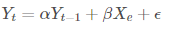

where Yt is value of the time series at time 't' and Xe is exogenous variable.

###### The presence of unit root means the time series is non-stationary.

###  Augmented Dickey-Fuller (ADF)

Augmented Dickey Fuller Test (ADF): test is a type of statistical test called a unit root test. Unit roots are a cause for non stationarity.

* <b>Null Hypothesis(H0)</b> : Time series has a unit root. ( Time series is not stationary).

* <b>Alternate Hypothesis(H1)</b>: Time Series has no unit root. (Time is stationary).

<b>If the null hypothesis can be rejected, we can conclude that the time series is stationary.</b>

There are two ways to rejects the null hypothesis:

On the onehand, the null hypothesis can be rejected if the p-value is below a set of significance level. The defaults significance level is 5%

* **p-value > significance level (default: 0.05)** : Fail to reject the null hypothesis (Ho),the data has a unit root and is non-stationary.

* **p-value <= significance level(default : 0.05)** : Reject the null hypothesis (H0), the data does not  have a unit root and is stationary.

On the other hand, the null hypothesis can be rejected if the test statistic is less than critical value.

* **ADF statistic > critical value** : Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

* **ADF statistic < critical value** : Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.8802016493166644,
 0.04769919092020832,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877625)

Now, we are going to check for each variable:

* The p-value is less than 0.5

* Check the range of the ADF statistic compared with critical_values

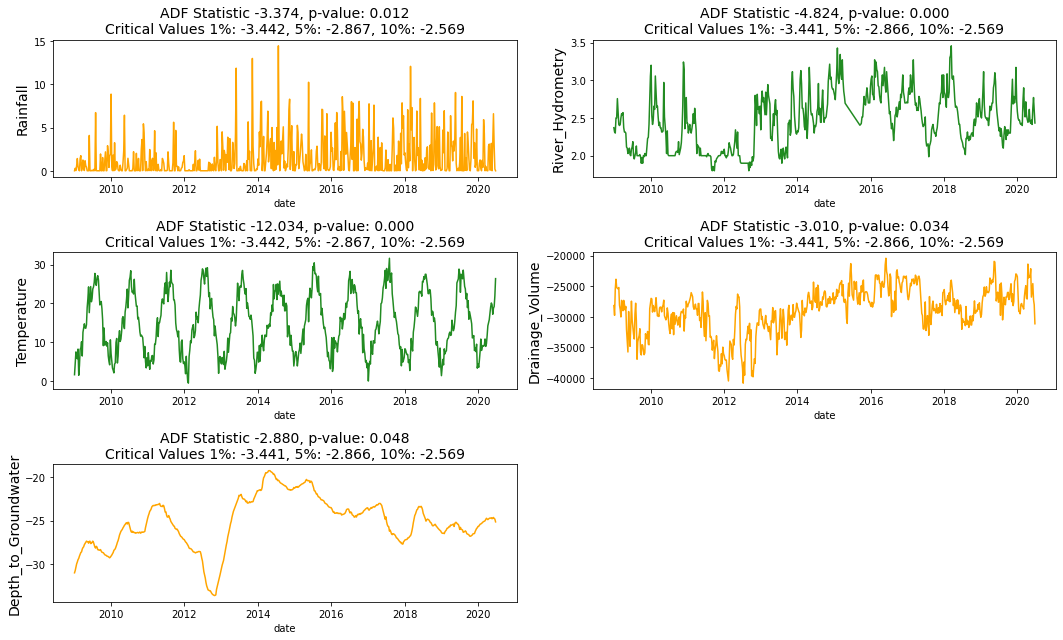

In [19]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'

    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    #the format string "{:0.3f}" tells the format() function to replace the bracketed expression with the floating point value, with only 3 decimal places.
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1]) # To remove the axes of empty subplot
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA(that needs this characteristic),the data has to be transformed.

The two most common methods to transform series into stationarity Ones are:

* **Transformation** : e.g. log or square root to stabilize non-constant variance
* **Differencing** : substracts the current value from the previous

<AxesSubplot:xlabel='depth_to_groundwater_log', ylabel='Density'>

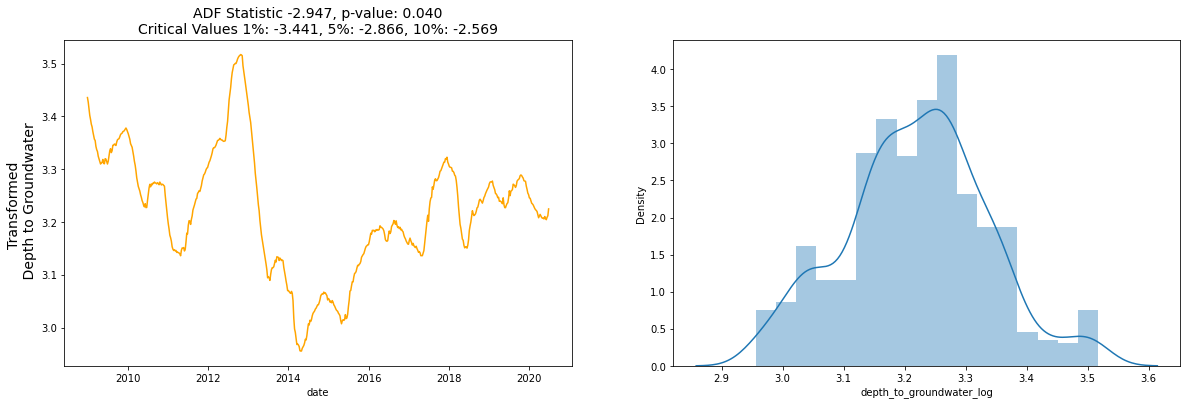

In [20]:
# Log Transform of absolute values
# (Log transform of negative values will return NaN)

df['depth_to_groundwater_log']=np.log(abs(df['depth_to_groundwater']))


f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
visualize_adfuller_results(df['depth_to_groundwater_log'],'Transformed \n Depth to Groundwater',ax[0])

sns.distplot(df['depth_to_groundwater_log'],ax=ax[1])

Differencing can be done in different orders:

* First Order differencing : linear trends with 

* Second order Differencing : quadratic trends 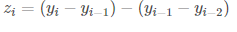

* and so..on

### Differencing

In [21]:
# First Order Differencing

ts_diff = np.diff(df['depth_to_groundwater'])

df['depth_to_groundwater_diff_1'] = np.append([0],ts_diff)


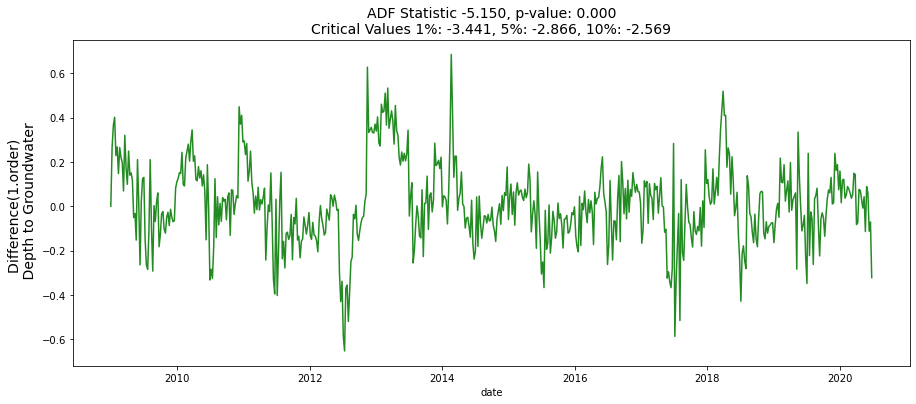

In [22]:
f,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,6))

visualize_adfuller_results(df['depth_to_groundwater_diff_1'],'Difference(1.order) \n Depth to Groundwater',ax)

# Feature Engineering

In [23]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day

df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year']= pd.DatetimeIndex(df['date']).weekofyear

df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] =  df['month'] % 12 // 3 + 1 # // is floor division, % is modulus operator remainder

In [24]:
df[['date','year','month','day','day_of_year','week_of_year','quarter','season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


## Encoding Cylindrical Features

The new time features are cyclical.

* E.g:- feature month cycles between 1 and 12 for every year.

while difference between each month increments by 1 during the year,between two years the feature jumps from 12(December) to 1(January). This is -11 difference, which can confuse  a lot of models

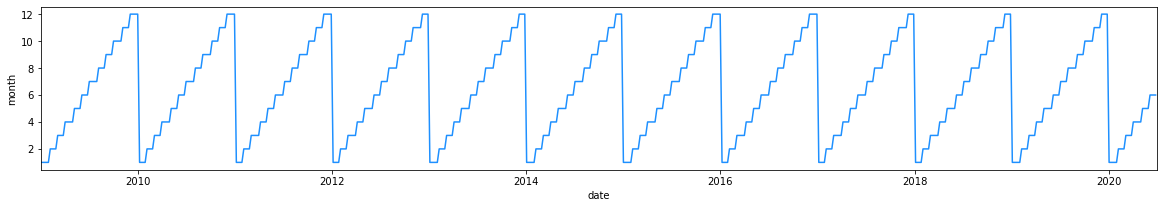

In [25]:
f, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,3))

sns.lineplot(x=df['date'],y=df['month'],color = 'dodgerblue')

ax.set_xlim([date(2009,1,1),date(2020,6,30)])

plt.show()

Lets encode this cyclical feature:

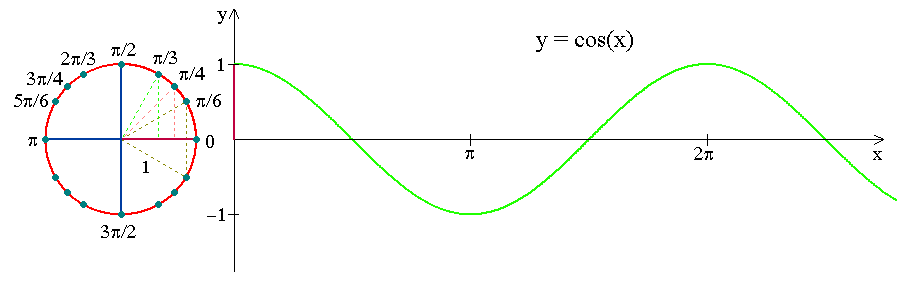

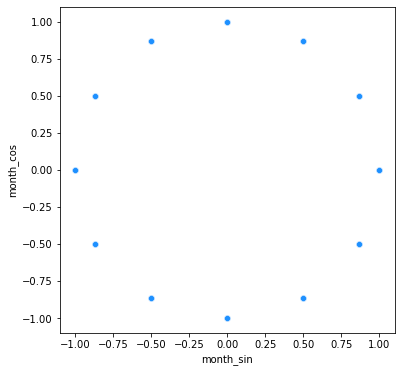

In [26]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

##  Time Series Decomposition


Time series decomposition involves thinking of a series as a combination of level,trend,seasonality and noise components.

These components are defined as follows.

* **Level:** The Average value in series

* **Trend:** The increasing and decreasing value in the series

* **Seasonality:** The repeating short-term cycle in the series

* **Noise:** The random variation in series

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is very helpful to think of the components as combining either additively or multiplicatively:





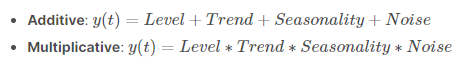

In this case we are going to use function seasonal_decompose() from stats library

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

### Eg: Of Enumerate Function

##### enumerate(iterable, startIndex)
* mylist = ['A', 'B' ,'C', 'D']
* e_list = enumerate(mylist)
* print(list(e_list))

**[(0, 'A'), (1, 'B'), (2, 'C'), (3, 'D')]**

* mylist = ['A', 'B' ,'C', 'D']
* e_list = enumerate(mylist,2)
* print(list(e_list))

**[(0, 'A'), (1, 'B'), (2, 'C'), (3, 'D')]**

* mylist = ['A', 'B' ,'C', 'D']

*for i in enumerate(mylist):
*  print(i)
*  print("\n")

* print("Using startIndex as 10")    

*for i in enumerate(mylist, 10):
*  print(i)
*  print("\n")
    
**(0, 'A')**


**(1, 'B')**


**(2, 'C')**


**(3, 'D')**


**Using startIndex as 10**

**(10, 'A')**


**(11, 'B')**


**(12, 'C')**


**(13, 'D')**

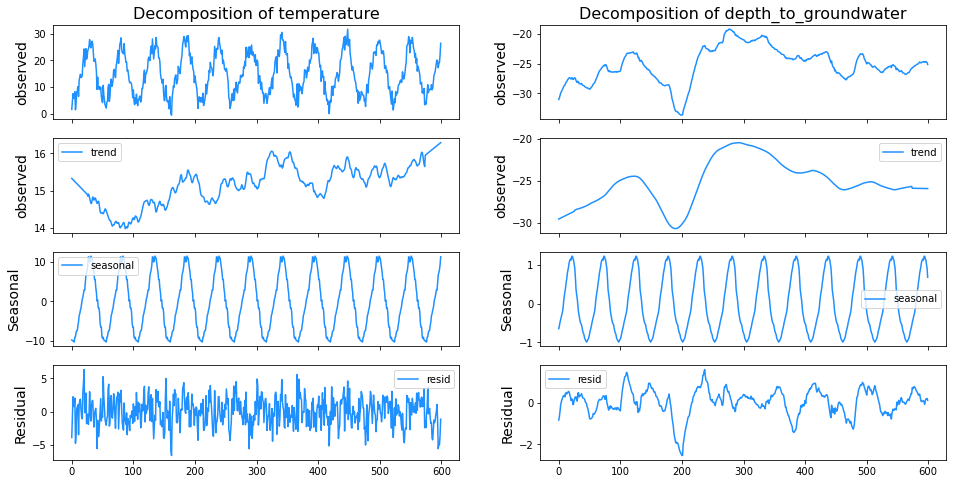

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['temperature','depth_to_groundwater']):
    res = seasonal_decompose(df[column],freq=52,model='additive',extrapolate_trend='freq')
    
    ax[0,i].set_title('Decomposition of {}'.format(column),fontsize=16)
    
    res.observed.plot(ax=ax[0,i],legend=False,color='dodgerblue')
    ax[0,i].set_ylabel('observed',fontsize=14)
    
    res.trend.plot(ax=ax[1,i], legend=True, color='dodgerblue')
    ax[1,i].set_ylabel('observed',fontsize=14)
    
    res.seasonal.plot(ax=ax[2,i],legend=True,color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i],legend=True,color='dodgerblue')
    ax[3,i].set_ylabel('Residual',fontsize=14)

plt.show()

##  Lag

We need to calculate each variable with a shift () (lag) to compare the correlation with the other variables.

You can see the documentation of shift function for more information.

In [29]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2*weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1*weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1*weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2*weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3*weeks_in_month)
                                           

# Exploratory Data Analysis

Now, we are going to plot the data and try to extract some knowledge

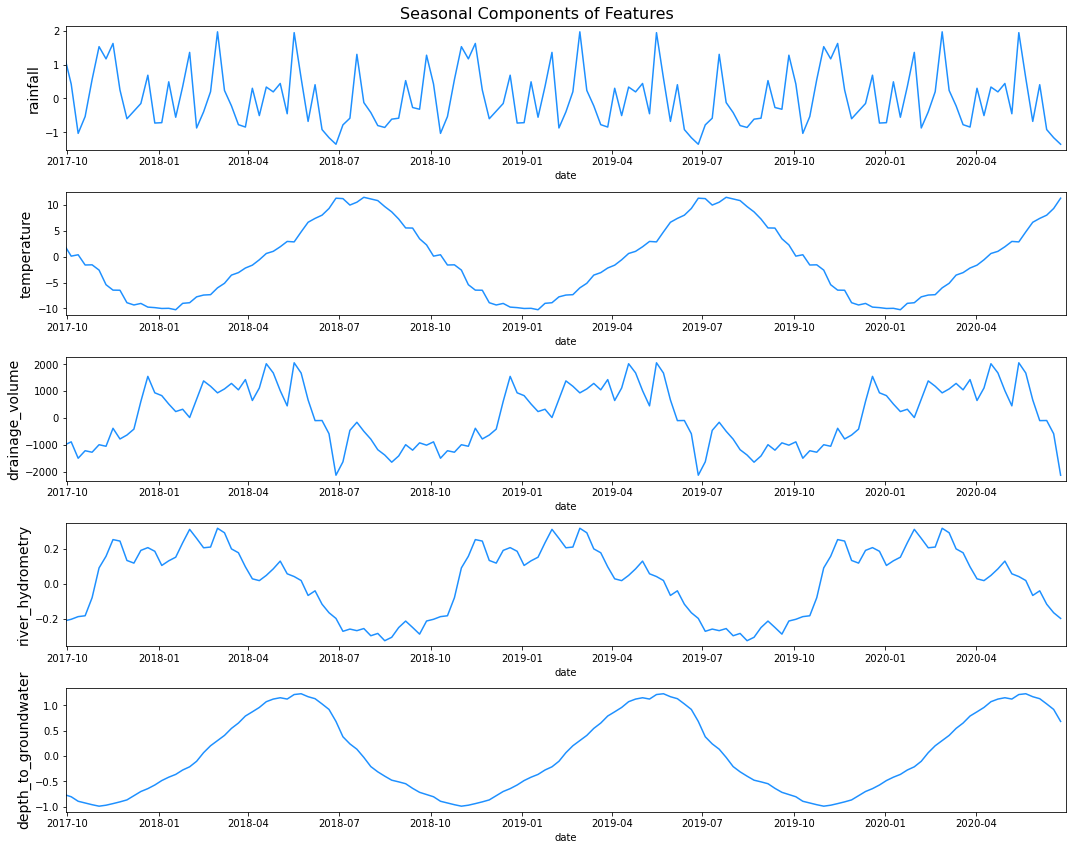

In [30]:
f, ax = plt.subplots(nrows=5,ncols=1,figsize=(15,12))

f.suptitle('Seasonal Components of Features',fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color = 'dodgerblue')
    ax[i].set_ylabel(ylabel=column,fontsize=14)
    ax[i].set_xlim([date(2017,9,30),date(2020,6,30)])
    
plt.tight_layout()
plt.show()

As we can see:

* **depth_to_groundwater:** reaches its maximum around May/June and its minimum around November

* **temperature:** reaches its maximum around August and its minimum around January

* **drainage_volume:** reaches its minimum around July

* **river_hydrometry:** reaches its maximum around February/March and its minimum around september

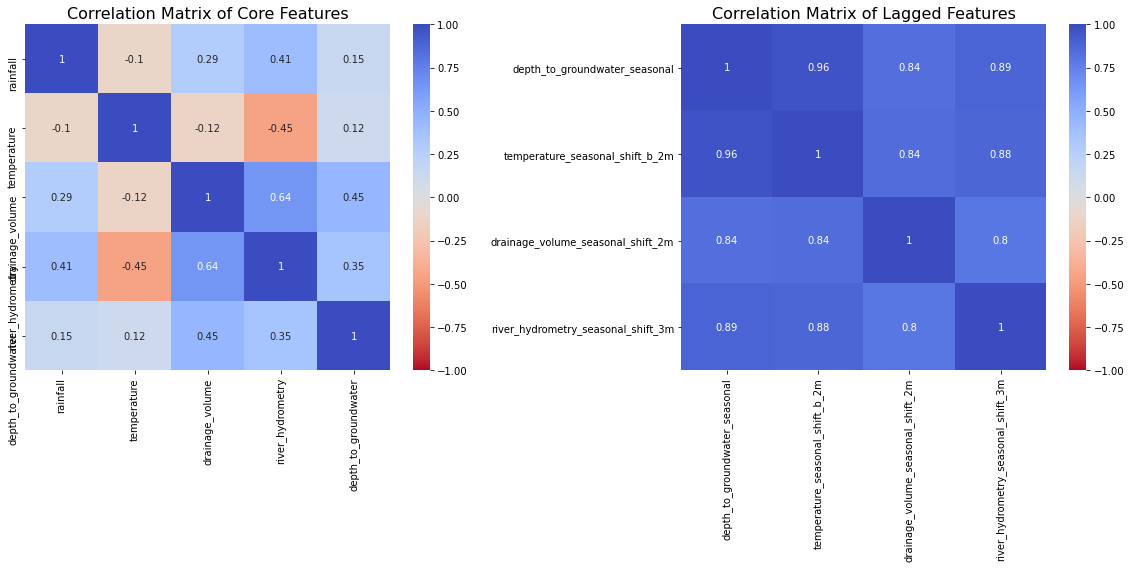

In [31]:
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])

ax[0].set_title('Correlation Matrix of Core Features',fontsize=16)

shifted_cols = ['depth_to_groundwater_seasonal','temperature_seasonal_shift_b_2m','drainage_volume_seasonal_shift_2m', 'river_hydrometry_seasonal_shift_3m']

corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat,annot=True,vmin=-1,vmax=1,cmap='coolwarm_r',ax=ax[1])

ax[1].set_title('Correlation Matrix of Lagged Features',fontsize=16)

plt.tight_layout()
plt.show()



As we can see, the features are highly correlated in the case of shifted features (lagged ones) than the original ones.

##  Autocorrelation Analysis

ACF and PACF plots : After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series.

Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best.

By looking at autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can alternatively identify the numbe of AR and/or MA terms that are needed.



* **Autocorrelation Function (ACF):**  P= Periods of lag for eg:(if P=3 then we will use the three previous periods of our time series in the auto regressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter.


* **Partial Autocorrelation Function (PACF):** D= In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plotting helps in detecting seasonality

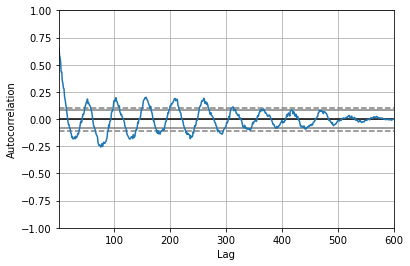

In [32]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

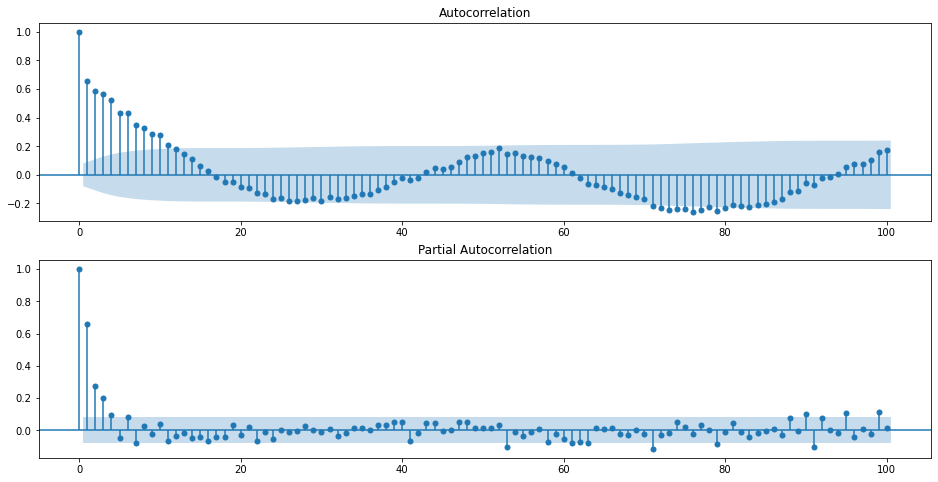

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

plot_acf(df['depth_to_groundwater_diff_1'],lags=100,ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])
plt.show()

# Modeling

Time series can be either univariate or multivariate:

* **Univariate:** time series only has a single time-dependent variable



* **Multivariate:** time series have a multiple time-dependent variable.

But, First of all we are going to see how does cross-validation technic works in TimeSeries Analysis.

In [34]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits = N_SPLITS)

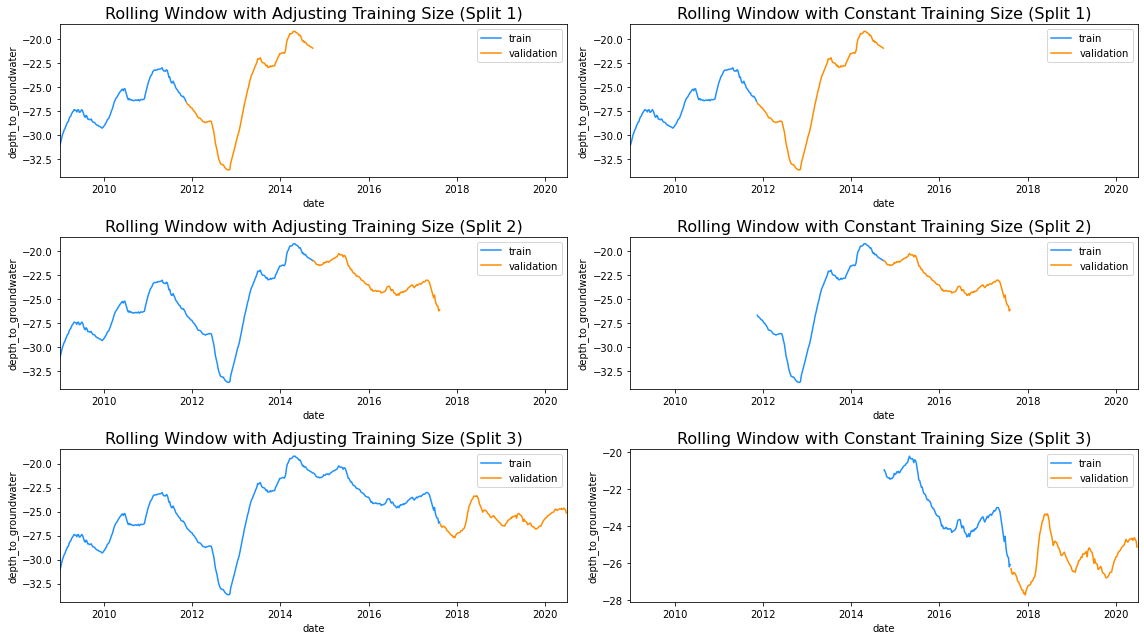

In [35]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

##  Models for Univariate Time Series

First of all, we are going to analyze univariate Time Series Forecasting

Univariate time series: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [36]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date','depth_to_groundwater']].copy()

univariate_df.columns = ['ds','y']

train = univariate_df.iloc[:train_size,:]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])

x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet.

Prophet, or **“Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.**

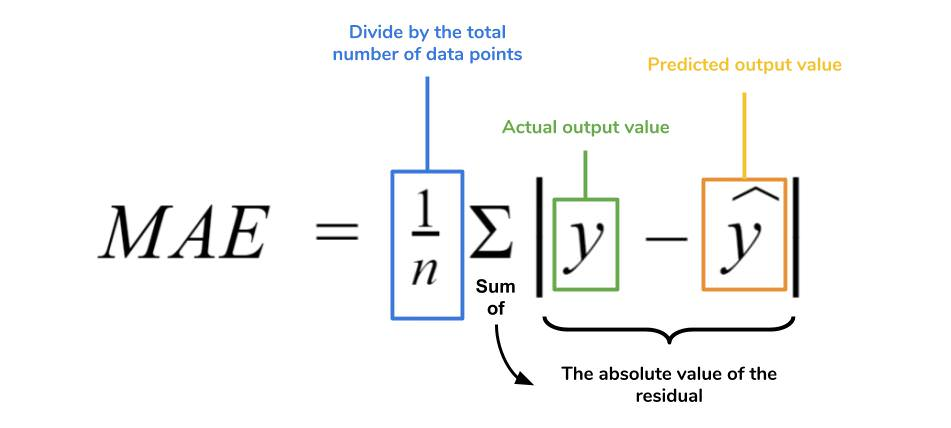

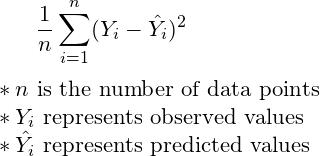

In [37]:
#!pip install fbprophet skipped

## ARIMA MODEL



The second model that i want to try is ARIMA.

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the autocorrelations in the data. The model assumes that the time-series is stationary. It consists of three main parts:

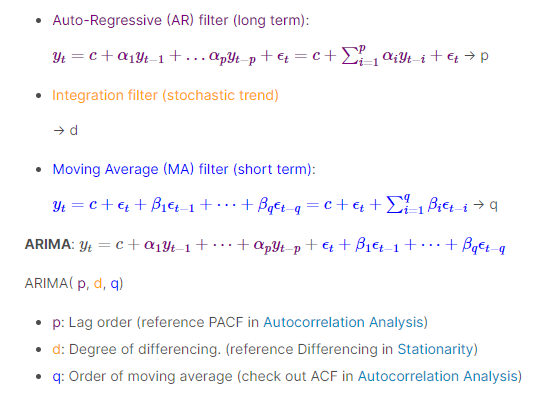

<B>Steps to analyze ARIMA</B>


**Step 1 — Check stationarity:** If a time series **has a trend or seasonality component**, it must be made stationary before we can use ARIMA to forecast.




**Step 2 — Difference:** If the time series is **not stationary**, it **needs to be stationarized through differencing**. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.

**Step 3 — Filter out a validation sample:** This will be used to validate how accurate our model is. Use train test validation split to achieve this

**Step 4 — Select AR and MA terms:** Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

**Step 5 — Build the model:** Build the model and set the number of periods to forecast to N (depends on your needs).


**Step 6 — Validate model:** Compare the predicted values to the actuals in the validation sample.

In [39]:
from statsmodels.tsa.arima_model import ARIMA

# Fit Model

model = ARIMA(y_train,order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA

y_pred, se, conf = model_fit.forecast(90)

# Calculate metrics

score_mae = mean_absolute_error(y_valid,y_pred)

score_rmse = math.sqrt(mean_absolute_error(y_valid,y_pred))

print(Fore.GREEN + 'RMSE:{}'.format(score_rmse))

RMSE:0.8608142044341284


https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide